# Useful Functions in Bifrost

With the basics of how to get data onto and off of the GPU, we can now start to look at useful functions in Bifrost.  Bifrost provides many functions that run on GPUs and interact via `bifrost.ndarray`s:

 * bifrost.fdmt - the fast dispersion measure transform
 * bifrost.fft - multi-dimensional Fourier transforms
 * bifrost.fir - finite impulse response (FIR) filters
 * bifrost.linalg- linear algebra module for matrix-matrix operations
 * bifrost.map - JIT functions for element-wise operations
 * bifrost.quantize - quantizers for moving between floating and integer types
 * bifrost.reduce - reduction (sum, min, max, etc.) array operations
 * bifrost.romein - data gridder
 * bifrost.transpose - data transpositions
 * bifrost.unpack - unpackers for moving between integer and floating types

We have already seen maps and FFTs in action so let's look at some of the other functions here.

## bifrost.reduce

`bifrost.reduce` is a complement to `bifrost.map` that deals with operations that reduce the size of an array, like a summation along an axis.

In [1]:
import bifrost, numpy
data = numpy.random.randn(10, 1000)
data = data.astype(numpy.float32)
sdata = data.sum(axis=1)
print('numpy:', sdata)

data = bifrost.ndarray(data, space='cuda')
sdata = bifrost.ndarray(shape=(data.shape[0], 1), dtype=sdata.dtype,
                        space='cuda')
bifrost.reduce(data, sdata, op='sum')
sdata2 = sdata.copy(space='system')
print('bifrost:', sdata2[:,0])

numpy: [ -5.5700846  36.078346   63.174416  -13.507341   15.61409    26.860054
 -48.392242  -37.947693   32.48661     0.6984892]
bifrost: [ -5.5700974  36.078346   63.174435  -13.507346   15.614068   26.860054
 -48.39224   -37.94771    32.486645    0.6984974]


During a reduction Bifrost uses the difference in the dimensions of the input and output arrays to determine what axis to run the reduction on.  Here we have summed along the second axis by setting that dimension to one for sdata.

In addition to sum, there are also reduction operations that work on power, i.e., magnitude squared:

In [2]:
data = numpy.random.randn(10, 1000)
data = data.astype(numpy.float32)
sdata = (data**2).sum(axis=1)
print('numpy:', sdata)

data = bifrost.ndarray(data, space='cuda')
sdata = bifrost.ndarray(shape=(data.shape[0], 1), dtype=sdata.dtype,
                        space='cuda')
bifrost.reduce(data, sdata, op='pwrsum')
sdata2 = sdata.copy(space='system')
print('bifrost:', sdata2[:,0])

numpy: [ 966.90137 1045.7456   932.72754  961.6767   956.31177 1002.28186
 1080.3342   964.5902   964.6155   971.55927]
bifrost: [ 966.9012  1045.7462   932.7264   961.676    956.3119  1002.2823
 1080.334    964.58997  964.61554  971.5588 ]


`bifrost.reduce` currently only support explicit reduction along one axies at a time.  However, it may be possible to run multi-dimensional reductions be reshaping the data:

In [3]:
data = numpy.random.randn(10, 1000)
data = data.astype(numpy.float32)
sdata = (data**2).sum()
print('numpy:', sdata)

data = bifrost.ndarray(data, space='cuda')
data = data.reshape(data.shape[0]*data.shape[1])
sdata = bifrost.ndarray(shape=(1,), dtype=sdata.dtype, space='cuda')
bifrost.reduce(data, sdata, op='pwrsum')
sdata2 = sdata.copy(space='system')
print('bifrost:', sdata2[0])

numpy: 10009.424
bifrost: 10009.425


## bifrost.transpose.transpose

For some data processing it may be more convenient to have the axis in a different order.  To transpose a GPU array in Bifrost there is the `bifrost.transpose` function:

In [4]:
data = numpy.random.randn(10, 1000)
data = data.astype(numpy.float32)
tdata = data.T.copy()
print('numpy:', data[0,9], '->', tdata[9,0])

data = bifrost.ndarray(data, space='cuda')
tdata = bifrost.ndarray(shape=data.shape[::-1], dtype=data.dtype,
                        space='cuda')
bifrost.transpose.transpose(tdata, data, axes=(1,0))
data2 = data.copy(space='system')
tdata2 = tdata.copy(space='system')
print('bifrost:', data2[0,9], '->', tdata2[9,0])

numpy: 0.97977257 -> 0.97977257
bifrost: 0.97977257 -> 0.97977257


Unlike `bifrost.reduce`, `bifrost.transpose.transpose` requires you to have both an output array with the correct shape and to explicitly specify the axis ordering in the call.

This function also support for general data re-ordering operations as well:

In [5]:
data = numpy.random.randn(10, 20, 30, 40)
data = data.astype(numpy.float32)
tdata = data.transpose(1,3,2,0).copy()
print('numpy:', data[1,3,5,7], '->', tdata[3,7,5,1])

data = bifrost.ndarray(data, space='cuda')
tdata = bifrost.ndarray(shape=[data.shape[v] for v in (1,3,2,0)],
                        dtype=data.dtype, space='cuda')
bifrost.transpose.transpose(tdata, data, axes=(1,3,2,0))
data2 = data.copy(space='system')
tdata2 = tdata.copy(space='system')
print('bifrost:', data2[1,3,5,7], '->', tdata2[3,7,5,1])

numpy: 0.9396533 -> 0.9396533
bifrost: 0.9396533 -> 0.9396533


## bifrost.fdmt

Bifrost includes a module for computing the fast dispersion measure transform of Zackay and Ofek (2017, ApJ 835 11) for incoherent dedispersion.  Like the `bifrost.fft` module using the FDMT requires some setup.  To get started let's make a simulation dispersed pulse at a DM of 5.5 pc cm^3:

Text(0, 0.5, 'Frequency [MHz]')

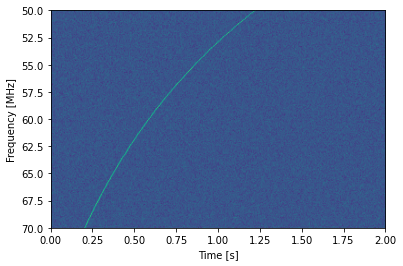

In [6]:
DM = 1.25
time = numpy.linspace(0, 2, 1000)
freq = numpy.linspace(50e6, 70e6, 200)
data = numpy.random.randn(freq.size, time.size)
data[:,100] += 10.0
data[:,101] += 8.0
data[:,102] += 4.0
data[:,103] += 1.0
for i in range(freq.size):
    delay = 4.15e-3 * DM * ((freq[i]/1e9)**-2 - (freq[-1]/1e9)**-2)
    delay = int(round(delay / (time[1] - time[0])))
    data[i,:] = numpy.roll(data[i,:], delay)
data = data.astype(numpy.float32)

import pylab
pylab.imshow(data, extent=(time[0], time[-1], freq[-1]/1e6, freq[0]/1e6))
pylab.axis('auto')
pylab.xlabel('Time [s]')
pylab.ylabel('Frequency [MHz]')

Now setup and run the FDMT on the data:

Text(0, 0.5, 'DM [pc cm$^{-3}$]')

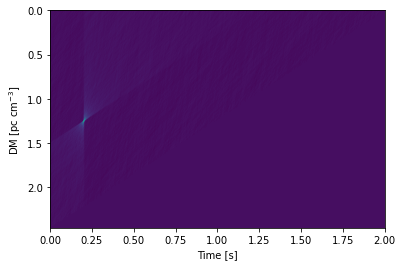

In [7]:
data = bifrost.ndarray(data, space='cuda')
ddata = bifrost.ndarray(shape=(time.size, time.size),
                        dtype=data.dtype, space='cuda')
f = bifrost.fdmt.Fdmt()
f.init(freq.size, time.size, freq[0]/1e6, (freq[1]-freq[0])/1e6)
f.execute(data, ddata)
ddata2 = ddata.copy(space='system')

tint = time[1] - time[0]
dm = numpy.arange(time.size)*1.0
dm *= tint / 4.15e-3 / ((freq[0]/1e9)**-2 - (freq[-1]/1e9)**-2)

pylab.imshow(ddata2, extent=(time[0], time[-1], dm[-1], dm[0]))
pylab.axis('auto')
pylab.xlabel('Time [s]')
pylab.ylabel('DM [pc cm$^{-3}$]')

## bifrost.linalg.LinAlg

The final useful function in Bifrost that we will explore is `bifrost.linalg.LinAlg`.  This function implements a varity of matrix-matrix operations.  It supports:

 * C = $\alpha$A $\times$ B + $\beta$ C
 * C = $\alpha$A $\times$ A$^{H}$ + $\beta$ C $-$ if B is not provided
 * C = $\alpha$B$^{H}$ $\times$ B + $\beta$ C $-$ if A is not provided

where $\alpha$ and $\beta$ are scalar values, $\times$ is a matrix product, and $^{H}$ denotes a Hermetian transpose.  For matricies with more than two dimensions the semantics are the same as for `numpy.matmul`:  The last two dims represent the matrix, and all other dimensions are used as batch dimensions to be matched or broadcast between A and B.

These three operations make this function useful for implementing simple beamformers or cross-correlation operations.  For a beamformer:

In [8]:
data = numpy.random.randn(1000, 32, 48)   # time, channel, input
data = data.astype(numpy.float32)         # beam, channel input
coeffs = numpy.ones((1, 32, 48))
for i in range(coeffs.shape[1]):
    coeffs[:,i] = i/32.0
coeffs = coeffs.astype(numpy.float32)
beam = numpy.matmul(coeffs.transpose(1,0,2), data.transpose(1,2,0))
beam = beam.transpose(2,0,1)               # time, channel, beam
print('numpy.matmul:', beam[0,10,0])
print('numpy manual:', (data[0,10,:]*coeffs[0,10,:]).sum())

data = bifrost.ndarray(data, space='cuda')
coeffs = bifrost.ndarray(coeffs, space='cuda')
beam = bifrost.ndarray(shape=(32,1,1000), dtype=numpy.float32,
                       space='cuda')
l = bifrost.linalg.LinAlg()
beam = l.matmul(1.0, coeffs.transpose(1,0,2), data.transpose(1,2,0),
                0.0, beam)
beam2 = beam.copy(space='system')
beam2 = beam2.transpose(2, 0, 1)
print('bifrost:', beam2[0,10,0])

numpy.matmul: 0.6552756
numpy manual: 0.6552757
bifrost: 0.65527564


This example illustrates one of the complexities when dealing with real data.  The axis order that makes the most sense for some operations may not be the best match for other operations.  Luckily `bifrost.linalg.LinAlg` supports at least some on-the-fly transpose operations and an explict transpose may not be necessary.

## Remaining Functions

The remaining functions of `bifrost.fir`, `bifrost.romein', `bifrost.quantize`, and `bifrost.unpack` will not be addressed here.  However, `bifrost.quantize` and `bifrost.unpack` will be used later in the tutorial.